In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from wordcloud import WordCloud

# Optional for better plots
sns.set(style='whitegrid')


In [27]:
file_path = r"C:\Users\Sudharshan.A\Downloads\drugs_side_effects_drugs_com.csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()

# Keep only necessary columns
df = df[['drug_name', 'medical_condition', 'side_effects', 'rating', 'no_of_reviews', 'rx_otc']].copy()

# Drop rows with missing values in key columns
df.dropna(subset=['drug_name', 'medical_condition', 'side_effects'], inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,drug_name,medical_condition,side_effects,rating,no_of_reviews,rx_otc
0,doxycycline,Acne,"(hives, difficult breathing, swelling in your ...",6.8,760,Rx
1,spironolactone,Acne,hives ; difficulty breathing; swelling of your...,7.2,449,Rx
2,minocycline,Acne,"skin rash, fever, swollen glands, flu-like sym...",5.7,482,Rx
3,Accutane,Acne,problems with your vision or hearing; muscle o...,7.9,623,Rx
4,clindamycin,Acne,hives ; difficult breathing; swelling of your ...,7.4,146,Rx


C:\Users\Sudharshan.A\AppData\Local\Temp\ipykernel_884\505670502.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='viridis')


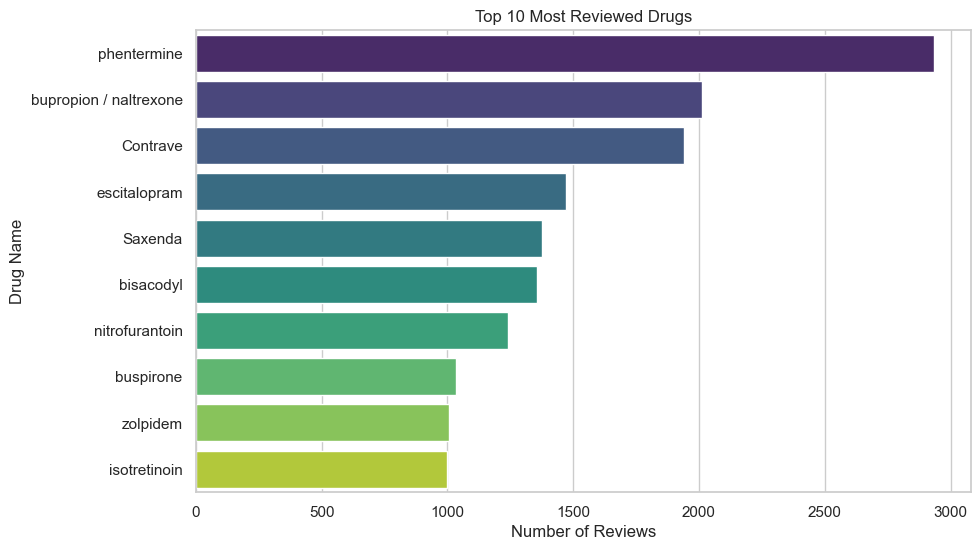

In [28]:
# 🛠️ Convert review counts to numeric
df['no_of_reviews'] = pd.to_numeric(df['no_of_reviews'], errors='coerce')

# Drop rows with missing or non-numeric reviews
df = df.dropna(subset=['no_of_reviews'])

# Group and plot
top_drugs = df.groupby('drug_name')['no_of_reviews'].sum().sort_values(ascending=False).head(10)

# 📊 Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_drugs.values, y=top_drugs.index, palette='viridis')
plt.title('Top 10 Most Reviewed Drugs')
plt.xlabel('Number of Reviews')
plt.ylabel('Drug Name')
plt.show()


In [29]:
# 🔡 Vectorize Side Effects
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X = tfidf.fit_transform(df['side_effects'])

print(f"TF-IDF matrix shape: {X.shape}")


TF-IDF matrix shape: (1547, 1000)


In [30]:
# 🔍 Clustering Drugs by Side Effects
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X)

os.environ["LOKY_MAX_CPU_COUNT"] = "4"  # or however many CPU cores your system has

df['cluster'] = clusters
df[['drug_name', 'medical_condition', 'cluster']].head()


,drug_name,medical_condition,cluster
0,doxycycline,Acne,1
1,spironolactone,Acne,1
2,minocycline,Acne,1
3,Accutane,Acne,1
4,clindamycin,Acne,2


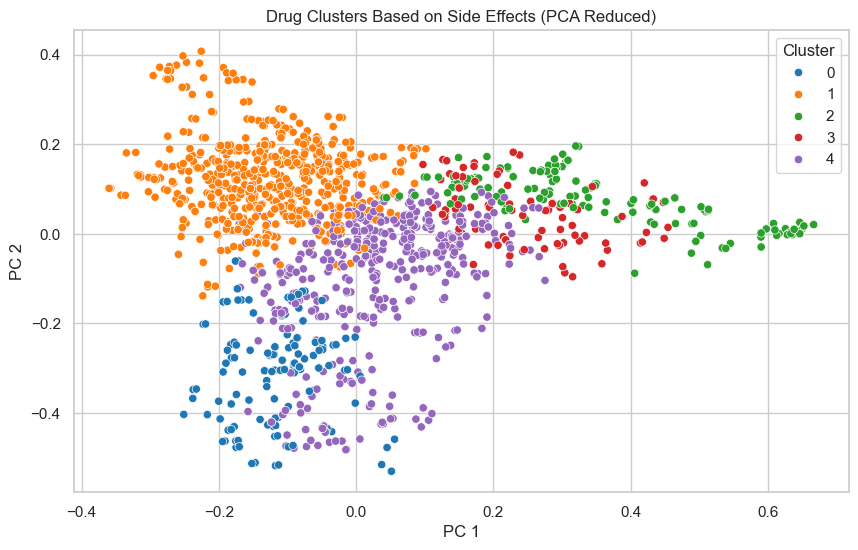

In [31]:
# 📉 Visualize Clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], palette='tab10')
plt.title("Drug Clusters Based on Side Effects (PCA Reduced)")
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(title='Cluster')
plt.show()


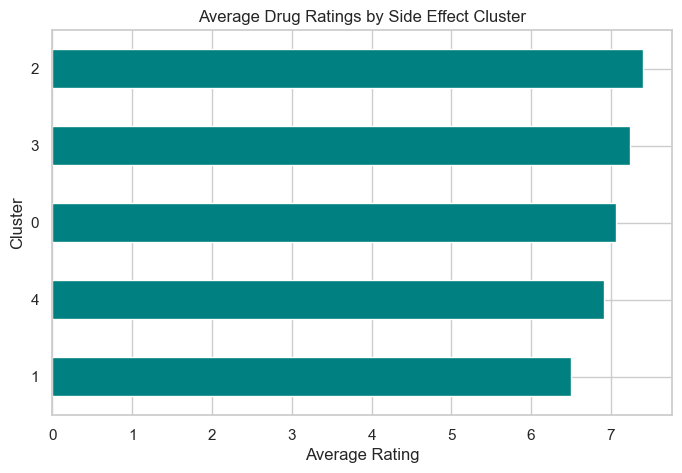

In [32]:
# 🛠️ Ensure rating is numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')

# Drop rows with missing ratings (if any)
df = df.dropna(subset=['rating'])

# ⭐ Average Ratings per Cluster
cluster_ratings = df.groupby('cluster')['rating'].mean().sort_values()

# 📊 Plot
cluster_ratings.plot(kind='barh', color='teal', figsize=(8, 5))
plt.title("Average Drug Ratings by Side Effect Cluster")
plt.xlabel("Average Rating")
plt.ylabel("Cluster")
plt.show()


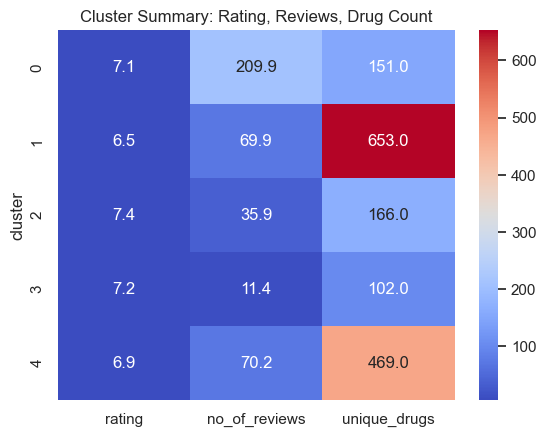

In [33]:
# 🔥 Heatmap of Aggregates per Cluster
agg = df.groupby('cluster').agg({
    'rating': 'mean',
    'no_of_reviews': 'mean',
    'drug_name': 'nunique'
}).rename(columns={'drug_name': 'unique_drugs'})

sns.heatmap(agg, annot=True, cmap='coolwarm', fmt=".1f")
plt.title('Cluster Summary: Rating, Reviews, Drug Count')
plt.show()
